In [1]:
#check cuda version 
!nvcc --version 
# install pytorch according to the cuda version from the pytorch website
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
# install mmcv
!pip install mmcv-full==1.1.4
#clone github repository
!git clone https://github.com/rubeea/focal_phi_loss_mmsegmentation.git 
#install all requirements
!pip install -qr focal_phi_loss_mmsegmentation/requirements.txt 
%cd /content/focal_phi_loss_mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'focal_phi_loss_mmsegmentation' already exists and is not an empty directory.
/content/focal_phi_loss_mmsegmentation
running develop
running egg_info
writing mmsegmentation.egg-info/PKG-INFO
writing dependency_links to mmsegmentation.egg-info/dependency_links.txt
writing requirements to mmsegmentation.egg-info/requires.txt
writing top-level names to mmsegmentation.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'mmsegmentation.egg-info/SOURCES.txt'
running build_ext
Creating

# Make data directories and upload the data in them

In [4]:
#declare global variables
root_dir= '/content/focal_phi_loss_mmsegmentation/data/'
data_root= "/content/focal_phi_loss_mmsegmentation/data/"
dataset= "ground_truth4_renkli"

In [5]:
import os

#script to extract data from zip files and create the directory structure for mendeley
#!python /content/focal_phi_loss_mmsegmentation/tools/convert_datasets/mendeley.py /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_gt.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_gt.zip 

#check file counts
train_imgs= data_root + dataset+'/img_dir/train'
val_imgs= data_root + dataset +'/img_dir/val'
train_gt= data_root + dataset+'/ann_dir/train'
val_gt= data_root + dataset+'/ann_dir/val'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

14
6
14
6


#Visualize training and mask images


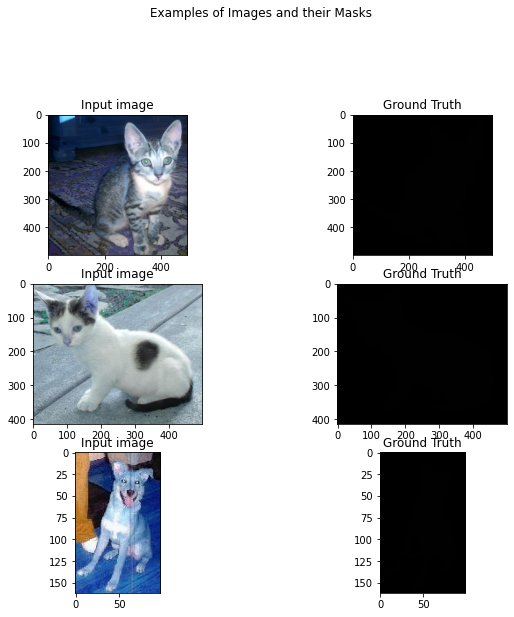

In [6]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+"/img_dir/train"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/train"
TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[120, 120, 120], [6, 230, 230]] #dataset palette

display_num = 5
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

#Create a config file


In [7]:
#config for ACU-Net
from mmcv import Config
cfg = Config.fromfile('/content/focal_phi_loss_mmsegmentation/configs/unet/fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py')

In [8]:
from mmseg.apis import set_random_seed
import torch

cfg_data_root = data_root+dataset
train_img_dir = 'img_dir/train'
train_ann_dir = 'ann_dir/train'
val_img_dir = 'img_dir/val'
val_ann_dir = 'ann_dir/val'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'MendeleyDataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2


#Balanced CE loss
#assign class weights to tackle the imbalanced nature of the dataset in balanced CE loss
# weights = [0.02, 0.98]
# cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, 
#                                             loss_weight=1.0, class_weight= weights)

#Dice Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.5, beta=0.5, gamma=1.0, use_focal=False, loss_weight=1.0)

#Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=1.0, use_focal=False, loss_weight=1.0)

#Focal Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=0.75, use_focal=True, loss_weight=1.0)

#MCC loss
# cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=1.0)

#Focal Phi Loss
cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=0.5)

#normalizing the dataset
cfg.img_norm_cfg = dict(
    mean= [142.393, 137.978, 83.073], std= [23.228, 20.046, 21.623], to_rgb=True) #for mendeley dataset

cfg.crop_size = (256, 256)

#dataset config
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 1.5)), #for mendeley dataset
    dict(type='RandomRotate', prob=0.5, degree=(45.0,315.0),pad_val=0,seg_pad_val=255), #for pldu and mendeley dataset
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale= (512, 512), #for mendeley dataset
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = val_img_dir
cfg.data.val.ann_dir = val_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = val_img_dir
cfg.data.test.ann_dir = val_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None


# Set up working dir to save files and logs.
cfg.work_dir = root_dir+'/work_dirs/tutorial'

cfg.total_iters = 160
cfg.log_config.interval = 50
cfg.evaluation.interval = 200 #validation at every 200 iterations
cfg.checkpoint_config.interval = 200

# Set seed to facilitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

#for Dice Loss, Tversky Loss and Focal Tversky Loss on Mendeley dataset use the following learning rates with Adam:
# lr = 5e-5

cfg.optimizer = dict(type='Adam', lr=1e-3, weight_decay=0.0001,
                     paramwise_cfg = dict(
                        custom_keys={
                            'head': dict(lr_mult=10.)
                        }
                        ))


# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='PhiLoss', lo

#Train the model according to the config


In [10]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmseg.utils import collect_env, get_root_logger
import mmcv
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]


meta = dict()
    # log env info
env_info_dict = collect_env()
env_info = '\n'.join([f'{k}: {v}' for k, v in env_info_dict.items()])
meta['env_info'] = env_info

meta['seed'] = cfg.seed
meta['exp_name'] = osp.basename(cfg.filename)
cfg.checkpoint_config.meta = dict(
            CLASSES=datasets[0].CLASSES,
            PALETTE=datasets[0].PALETTE)

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=meta)

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2022-07-19 14:44:54,168 - mmseg - INFO - Loaded 14 images


RuntimeError: ignored